In [1]:
import os
import math
import numpy as np
import pandas as pd
import rfit
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")
print("\nReady to continue.")


Ready to continue.


In [2]:
df = pd.read_csv('train.csv', header=0)
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Project tasks and goals:

 1. Use this Housing Price dataset.
 - Use SalePrice as target for K-NN regression.
 - For features that are *ORDINAL*, recode them as 0,1,2,...
 - Drop features that are purely categorical.
 2. Modify the sknn class to perform K-NN regression.
 3. Modify the sknn class as you see fit to improve the algorithm performance, logic, or presentations.
 3. Find optimized scaling factors for the features for the best model score.
 4. Modify the sknn class to save some results (such as scores, scaling factors, gradients, etc, at various points, like every 100 epoch).
 5. Compare the results of the optimized scaling factors to Feature Importance from other models, such as Tree regressor for example.

 Please ask me anything about this project. You can either work individually or team with one other student
 to complete this project.

 You/your team need to create a github repo (private) and add myself (physicsland) as a collaborator.
 Please setup an appropriate .gitignore as the first thing when you create a repo.



## Data Cleaning

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('train.csv', header=0)
print(f"Original Data Shape: {df.shape}")


categorical_columns = ["Id", "MSSubClass", "MSZoning", "Street", "Alley", "LotConfig", "Neighborhood", "Condition1",
                       "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                       "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", "GarageType", "MiscFeature"]

numerical_columns = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
                     'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
                     'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LowQualFinSF', 'MasVnrArea',
                     'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch',
                     'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']

ordinal_mapping = {
    'LotShape': {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3},
    'LandContour': {'Lvl': 0, 'Bnk': 1, 'HLS': 2, 'Low': 3},
    'Utilities': {'AllPub': 1, 'NoSewr': 2, 'NoSeWa': 3, 'ELO': 4},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'ExterQual': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4},
    'ExterCond': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4},
    'BsmtQual': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4, 'NA': 5},
    'BsmtCond': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4, 'NA': 5},
    'BsmtExposure': {'Gd': 0, 'Av': 1, 'Mn': 2, 'No': 3, 'NA': 4},
    'BsmtFinType1': {'GLQ': 0, 'ALQ': 1, 'BLQ': 2, 'Rec': 3, 'LwQ': 4, 'Unf': 5, 'NA': 6},
    'BsmtFinType2': {'GLQ': 0, 'ALQ': 1, 'BLQ': 2, 'Rec': 3, 'LwQ': 4, 'Unf': 5, 'NA': 6},
    'HeatingQC': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4},
    'KitchenQual': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4},
    'FireplaceQu': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4, 'NA': 5},
    'GarageFinish': {'Fin': 0, 'RFn': 1, 'Unf': 2, 'NA': 3},
    'GarageQual': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4, 'NA': 5},
    'GarageCond': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4, 'NA': 5},
    'PavedDrive': {'Y': 0, 'P': 1, 'N': 2},
    'PoolQC': {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'NA': 4},
    'Fence': {'GdPrv': 0, 'MnPrv': 1, 'GdWo': 2, 'MnWw': 3, 'NA': 4},
    'Functional': {'Typ': 0, 'Min1': 1, 'Min2': 1, 'Mod': 2, 'Maj1': 3, 'Maj2': 3, 'Sev': 4, 'Sal': 5}
}

low_correlation_features = ['PoolArea', 'Utilities', 'MiscVal', 'LotFrontage', 'GarageYrBlt']
target_related_features = ['YrSold', 'MoSold', 'SaleType', 'SaleCondition']

df = df.fillna('NA')
for col, mapping in ordinal_mapping.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)
    else:
        print(f"Column {col} is missing from the dataset.")

df = df.drop(columns=categorical_columns + low_correlation_features + target_related_features)

df = df.replace('NA', np.nan)
df = df.dropna().reset_index(drop=True)

target = df['SalePrice']
features = df.drop(['SalePrice'], axis=1)


Original Data Shape: (1460, 81)


In [4]:
class sknn:
    '''
    Scaling k-NN model
    v2
    Using gradient to find max
    '''
    import os
    import math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neighbors import KNeighborsRegressor
    # from sklearn.linear_model import LogisticRegression
    # from sklearn.svm import SVC, LinearSVC
    # from sklearn.tree import DecisionTreeClassifier

    # contructor and properties
    def __init__(self, 
                 data_x, 
                 data_y, 
                 resFilePfx='results', 
                 classifier=True, 
                 k=7, 
                 kmax=33, 
                 zscale=True, 
                 caleExpos_init = (), 
                 scales_init = (), 
                 ttsplit=0.5, 
                 max_iter = 100, 
                 seed=1, 
                 scoredigits = 6, 
                 learning_rate_init = 0.1, 
                 atol = 1e-8,
                 save_iter = 10 ) :
        """
        Scaling kNN model, using scaling parameter for each feature to infer feature importance and other info about the manifold of the feature space.

        Args:
            data_x (numpy ndarray or pandas DataFrame): x-data
            data_y (numpy ndarray or pandas Series or DataFrame): y-data
            resFilePfx (str, optional): result file prefix. Defaults to 'scores'.
            classifier (bool, optional): classifier vs regressor. Defaults to True.
            k (int, optional): k-value for k-N. Defaults to 7.
            kmax (int, optional): max k-value. Defaults to 33.
            zscale (bool, optional): start with standardized z-score. Defaults to True.
            probeExpos (tuple, optional): Tuple of the exponents for scaling factors. Defaults to ().
            scaleExpos (tuple, optional): Tuple of the scaling factors. Defaults to ().
            ttsplit (float, optional): train-test-split ratio. Defaults to 0.5.
            max_iter (int, optional): maximum iteration. Defaults to 100.
            seed (int, optional): seed value. Defaults to 1.
            scoredigits (int, optional): number of digitis to show/compare in results. Defaults to 6.
            learning_rate_init (float, optional): learning rate, (0,1]. Defaults to 0.01.
            tol (_type_, optional): tolerance. Defaults to 1e-4.
        """
        self.__classifierTF = classifier  # will extend to regression later
        self.k = k
        self.__kmax = kmax
        self.__iter = 0 # the number of trials/iterations
        self.max_iter = max_iter
        self.__seed = seed
        self.__scoredigits = scoredigits
        # self.__resFilePfx = resFilePfx
        self.__learning_rate_init = abs(learning_rate_init)
        self.learning_rate = abs(learning_rate_init)
        self.__atol = atol
        self.__save_iter = save_iter
        
        # prep data
        self.data_x = data_x
        self.data_xz = data_x # if not to be z-scaled, same as original
        self.zscaleTF = zscale
        # transform z-score 
        if (self.zscaleTF): self.zXform() # will (re-)set self.data_xz
        self.data_y = data_y
        # train-test split
        self.__ttsplit = ttsplit if (ttsplit >=0 and ttsplit <= 1) else 0.5 # train-test split ratio
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.__xdim = 0  # dimension of feature space
        self.traintestsplit() # will set X_train, X_test, y_train, y_test, __xdim
        # set x data column names
        # self.__Xcolnames = (); self.__setXcolnames()
        self.__vector0 = np.zeros(self.__xdim)
        # self.__vector1 = np.ones(self.__xdim)
        
        # set exponents and scaling factors 
        self.__scaleExpos = [] # tuple or list. length set by number of features. Because of invariance under universal scaling (by all features with same factor), we can restrict total sum of exponents to zero.
        # self.__scaleExpos_init = [] # tuple or list. length set by number of features
        self.__scaleFactors = None # numpy array. always calculate from self.__setExpos2Scales
        self.__setExpos2Scales([]) # will set the initial self.scaleExpos and self.__scaleFactors
        # self.__gradients = [] # partial y/partial exponents (instead of partial scaling factors)
        
        # set sklearn knnmodel objects, train, and get benchmark scores on test data
        self.__knnmodels = [np.nan, np.nan] # matching index value as k value
        for i in range(2,self.__kmax +1): 
            if (self.__classifierTF): 
                self.__knnmodels.append( KNeighborsClassifier(n_neighbors=i, weights='uniform').fit(self.X_train, self.y_train ) )
            else: 
                self.__knnmodels.append( KNeighborsRegressor(n_neighbors=i, weights='uniform').fit(self.X_train, self.y_train ) ) # TODO
        self.benchmarkScores = [np.nan, np.nan] +  [ round(x.score(self.X_test, self.y_test ), self.__scoredigits) for x in self.__knnmodels[2:] ]
        print(f'These are the basic k-NN scores for different k-values: {repr(self.benchmarkScores)}, where no individual feature scaling is performed.') 
        
        self.__results = []
        
    # END constructor
    
    def zXform(self):
        '''
        standardize all the features (if zscale=True). Should standardize/scale before train-test split
        :return: None
        '''
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        self.data_xz = scaler.fit_transform(self.data_x)  # data_x can be ndarray or pandas df, data_xz will be ndarray
        return
    
    def traintestsplit(self):
        '''
        train-test split, 50-50 as default
        :return: None
        '''
        # train-test split
        from sklearn.model_selection import train_test_split
        # data_y can be pd series here, or 
        dy = self.data_y.values if (isinstance(self.data_y, pd.core.series.Series) or isinstance(self.data_y, pd.core.frame.DataFrame)) else self.data_y # if (isinstance(data_y, np.ndarray)) # the default
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data_xz, dy, test_size=self.__ttsplit, random_state = self.__seed)
        # these four sets should be all numpy ndarrays.

        nrows_Xtest, self.__xdim = self.X_test.shape  # total rows and columns in X_test. # not needed for nrows
        # notice that 
        # self.__xdim == self.X_test.shape[1]   # True
        # self.__xdim is self.X_test.shape[1]   # True
        # nrows_Xtest == self.X_test.shape[0]   # True
        # nrows_Xtest is self.X_test.shape[0]   # False
        return

    # def __setProbeExpos(self, expos):
    #     '''
    #     set Probing Exponents, a tuple
    #     param expos: list/tuple of floats
    #     :return: None
    #     '''
    #     # Can add more checks to ensure expos is numeric list/tuple
    #     self.__probeExpos = expos if (len(expos)>2) else (-6, -3, -1, -0.5, 0, 0.5, 1, 1.5, 2, 4, 6) # tuple, exp(tuple) gives the scaling factors.
    #     self.__probeFactors = tuple( [ math.exp(i) for i in self.__probeExpos ] )
    #     return

    def __setExpos2Scales(self, expos=[]):
        """
        set Scaling Exponents, a tuple or list
        Should make sure expos is centered (using __shiftCenter)

        Args:
            expos (list, optional): _description_. Defaults to [], should match number of features in data_x
        """

        # Can add more checks to ensure expos is numeric list/tuple
        if (len(expos) != self.__xdim):
            self.__scaleExpos = np.zeros(self.__xdim) # tuple, exp(tuple) gives the scaling factors.
            if self.__xdim >1: 
                self.__scaleExpos[0] = 1
                self.__scaleExpos[1] = -1
        else:
            self.__scaleExpos =  expos
        self.__scaleFactors = np.array( [ math.exp(i) for i in self.__scaleExpos ] ) # numpy array
        return
    
    def __shiftCenter(self, expos = []):
        """
        Enforce sum of exponents or any vectors like gradient = 0 (for xdim > 1)

        Args:
            expos (np array, optional): array of scaling exponents. Defaults to [].
        """
        return expos.copy() - expos.sum()/len(expos) if len(expos) > 1 else expos.copy()
        
    
    def __evalGradients(self, learning_rate=0, use = 'test'):
        """
        evaluate Gradients/partial derivatives with respect to exponential factors (not scaling factor)
        Args:
            learning_rate (float, optional): learning_rate. Defaults to 0.
            use (str, optional): use 'test' (default) or 'train' dataset to score. 
        """
        # set learning_rate
        grad = np.array( [ self.__eval1Gradient(i, learning_rate, use=use) for i in range(self.__xdim) ] )
        # normalize grad here?
        # self.__gradients = grad.copy()
        # return
        return grad # gradient as numpy array
    
    def __eval1Gradient(self, i, learning_rate=0, use='test'):
        """
        evaluate a single Gradient/partial derivative with respect to the exponential factor (not scaling factor)

        Args:
            i (int): the column/feature index.
            learning_rate (float, optional): learning_rate. Defaults to 0.
            use (str, optional): use 'test' (default) or 'train' dataset to score. 
        """
        thescale = self.__scaleExpos[i]
        thestep = max(learning_rate, self.learning_rate, abs(thescale)*self.learning_rate ) # modify step value appropriately if needed.
        # maxexpo = thescale + thestep/2
        # minexpo = thescale - thestep/2
        maxexpos = self.__scaleExpos.copy()
        maxexpos[i] += thestep/2
        minexpos = self.__scaleExpos.copy()
        minexpos[i] -= thestep/2
        slope = ( self.scorethis(scaleExpos=maxexpos, use=use) - self.scorethis(scaleExpos=minexpos, use=use) ) / thestep
        return slope
    
    def __setNewExposFromGrad(self, grad=() ):
        """
        setting new scaling exponents, from the gradient info
        steps: 
        1. center grad (will take care of both grad = 0 and grad = (1,1,...,1) cases)
        2. normalize grad (with learning rate as well)
        3. add to original expos

        Args:
            grad (tuple, optional): the gradient calculated. Defaults to empty tuple ().
        """
        grad = self.__shiftCenter(grad)
        if np.allclose(grad, self.__vector0, atol=self.__atol): 
            print(f"Gradient is zero or trivial: {grad}, \n__scaleExpos= {self.__scaleExpos}, \n__scaleFactors= {self.__scaleFactors}, \nmodel score-train is {self.scorethis(use='train')}, \nscore-test is {self.scorethis(use='test')}\n")
            return False
        norm = np.sqrt( np.dot(grad,grad) )
        deltaexpos = grad / norm * self.learning_rate
        self.__scaleExpos += deltaexpos
        self.__setExpos2Scales(self.__scaleExpos)
        return True
    
    def optimize(self, scaleExpos_init = (), maxiter = 1000, learning_rate=0):
        """
        Optimizing scaling exponents and scaling factors

        Args:
            scaleExpos_init (np array, optional): initial search vector. Defaults to empty.
            maxiter (int, optional): max iteration. Defaults to 1e3.
            learning_rate (float, optional): learning_rate. Defaults to 0 or self.learning_rate
        """
        maxi = max( self.max_iter, maxiter)
        skip_n = 10 # rule of thumb math.floor(1/learning_rate)
        expos = scaleExpos_init 
        if (len(scaleExpos_init) == self.__xdim): self.__scaleExpos = scaleExpos_init # assumes the new input is the desired region.
        print(f"Begin: \n__scaleExpos= {self.__scaleExpos}, \n__scaleFactors= {self.__scaleFactors}, \nmodel score-train is {self.scorethis(use='train')}, \nscore-test is {self.scorethis(use='test')}, \nmaxi= {maxi}, k={self.k}, learning_rate={self.learning_rate}\n")
        for i in range(maxi):
            grad = self.__evalGradients(learning_rate, use='train')
            # Cases
            # 1. grad = 0, stop (built into __setNewExposFromGrad)
            # 2. grad parallel to (1,1,1,...,1) direction, stop.
            # 3. maxiter reached, stop. (end of loop)
            # 4. ?? dy < tol, stop??            # 
            result = self.__setNewExposFromGrad(grad)

            if i % self.__save_iter == 0:
                self.__results.append(
                    {'iteration': i,
                    'scaleExpos': self.__scaleExpos,
                    'scaleFactors': self.__scaleFactors,
                    'gradients': grad,
                    'train_score': self.scorethis(use='train'),
                    'test_score': self.scorethis(use='test')}
                )

            if (i<10 or i%skip_n==0 ): print(f"i: {i}, |grad|^2={np.dot(grad,grad)}, \ngrad= {grad}, \n__scaleExpos= {self.__scaleExpos}, \n__scaleFactors= {self.__scaleFactors}, \nmodel score-train is {self.scorethis(use='train')}, \nscore-test is {self.scorethis(use='test')}\n")
            if not result: break
            
        if i==maxi-1: print(f"max iter reached. Current |grad|^2={np.dot(grad,grad)}, \ngrad= {grad}, \n__scaleExpos= {self.__scaleExpos}, \n__scaleFactors= {self.__scaleFactors}, \nmodel score-train is {self.scorethis(use='train')}, \nscore-test is {self.scorethis(use='test')}\n")
            
    def resultsDF(self):
        return pd.DataFrame(self.__results)
    
    def resultsPlot(self):
        self.resultsDF().plot(x='iteration', y=['train_score', 'test_score'], title='Scores vs Iteration')

    def feature_importance(self, feature_names):
        importance = self.__scaleFactors / self.__scaleFactors.sum()
        return pd.DataFrame({'feature': feature_names, 'importance': importance}).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    def scorethis(self, scaleExpos = [], scaleFactors = [], use = 'test'):
        if len(scaleExpos)==self.__xdim :
            self.__setExpos2Scales( self.__shiftCenter(scaleExpos) )
        # elif len(scaleFactors)==self.__xdim:
        #     self.__scaleFactors = np.array(scaleFactors)
        #     self.__scaleExpos = [ round(math.log(x), 2 ) for x in scaleFactors ]
        else:
            # self.__setExpos2Scales(np.zeros(self.__xdim))
            if (len(scaleExpos)>0 or len(scaleFactors)>0) : print('Scale factors set to default values of unit (all ones). If this is not anticipated, please check your input, making sure the length of the list matches the number of features in the dataset.')
        
        sfactors = self.__scaleFactors.copy() # always start from the pre-set factors, whatever it might be
        self.__knnmodels[self.k].fit(sfactors*self.X_train, self.y_train)
        # For optimizing/tuning the scaling factors, use the train set to tune. 
        newscore = self.__knnmodels[self.k].score(sfactors*self.X_train, self.y_train) if use=='train' else self.__knnmodels[self.k].score(sfactors*self.X_test, self.y_test)
        return newscore

###### END class sknn

These are the basic k-NN scores for different k-values: [nan, nan, 0.738434, 0.744219, 0.762066, 0.772349, 0.77522, 0.779404, 0.77823, 0.779867, 0.785178, 0.78817, 0.787837, 0.786195, 0.785605, 0.786533, 0.782432, 0.783454, 0.782153, 0.781122, 0.777723, 0.77682, 0.774073, 0.772216, 0.771768, 0.770245, 0.770101, 0.769095, 0.766081, 0.764813, 0.76443, 0.762795, 0.76164, 0.759097], where no individual feature scaling is performed.
Initial Train Score: 0.8355901315637055
Initial Test Score: 0.7773703417887816
Begin: 
__scaleExpos= [ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.], 
__scaleFactors= [2.71828183 0.36787944 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1

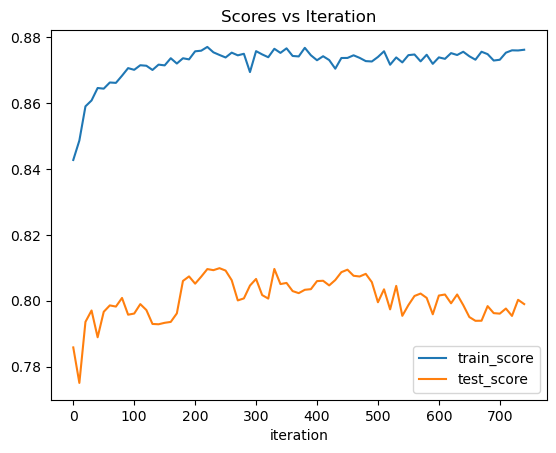

In [ ]:
model = sknn(data_x=features.values, data_y=target.values, classifier=False, k=7)

train_score_initial = model.scorethis(use='train')
test_score_initial = model.scorethis(use='test')

print("Initial Train Score:", train_score_initial)
print("Initial Test Score:", test_score_initial)

model.optimize(maxiter=750)
train_score_optimized = model.scorethis(use='train')
test_score_optimized = model.scorethis(use='test')

print("Optimized Train Score:", train_score_optimized)
print("Optimized Test Score:", test_score_optimized)

model.resultsPlot()

In [6]:
X = model.X_train
y = model.y_train

def feature_importance(importance):
        return pd.DataFrame({'feature': features.columns, 'importance': importance}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [7]:
# SKNN
feature_importance_sknn = model.feature_importance(features.columns)
print(feature_importance_sknn)

          feature  importance
0    KitchenAbvGr    0.055094
1      GarageCond    0.054887
2          PoolQC    0.054129
3      GarageQual    0.045114
4         LotArea    0.041419
5    YearRemodAdd    0.032840
6      BsmtFinSF2    0.032680
7       GrLivArea    0.030896
8     OverallQual    0.026249
9      Functional    0.023642
10    FireplaceQu    0.022369
11   BsmtFinType2    0.021582
12   TotRmsAbvGrd    0.020678
13       BsmtQual    0.020160
14   LowQualFinSF    0.019984
15     BsmtFinSF1    0.019953
16     PavedDrive    0.019691
17      3SsnPorch    0.019623
18    OpenPorchSF    0.019584
19          Fence    0.019189
20   GarageFinish    0.018066
21      ExterCond    0.017873
22      HeatingQC    0.017611
23       1stFlrSF    0.017569
24   BsmtExposure    0.016821
25       FullBath    0.016736
26   BsmtHalfBath    0.016637
27    LandContour    0.016303
28     Fireplaces    0.016250
29     GarageArea    0.016027
30     GarageCars    0.015995
31       BsmtCond    0.015831
32   Bedro

In [8]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X, y)
feature_importance_dt = feature_importance(dt.feature_importances_)
print(feature_importance_dt)

          feature  importance
0        1stFlrSF    0.057380
1     TotalBsmtSF    0.053514
2       GrLivArea    0.051597
3      GarageArea    0.044106
4       BsmtUnfSF    0.042756
5         LotArea    0.040358
6      BsmtFinSF1    0.039529
7       YearBuilt    0.038332
8        2ndFlrSF    0.036001
9      WoodDeckSF    0.035782
10    OpenPorchSF    0.035693
11     MasVnrArea    0.032658
12   TotRmsAbvGrd    0.032365
13   YearRemodAdd    0.031776
14   BsmtFinType1    0.025532
15    OverallCond    0.024375
16    FireplaceQu    0.023917
17    OverallQual    0.023129
18   BsmtExposure    0.023000
19       BsmtQual    0.022053
20      HeatingQC    0.021802
21   GarageFinish    0.019851
22          Fence    0.018373
23       LotShape    0.018103
24    KitchenQual    0.017806
25   BsmtFullBath    0.015880
26      ExterCond    0.015696
27   BsmtFinType2    0.015270
28   BedroomAbvGr    0.014750
29  EnclosedPorch    0.013540
30      ExterQual    0.012872
31     Fireplaces    0.012839
32     Gar

In [9]:
# Random Forest
rf = RandomForestClassifier(random_state=0)
rf.fit(X, y)
feature_importance_rf = feature_importance(rf.feature_importances_)
print(feature_importance_rf)


          feature  importance
0       GrLivArea    0.053094
1         LotArea    0.052357
2        1stFlrSF    0.051026
3      GarageArea    0.048895
4       BsmtUnfSF    0.048770
5     TotalBsmtSF    0.048354
6       YearBuilt    0.047445
7    YearRemodAdd    0.042041
8      BsmtFinSF1    0.041622
9     OpenPorchSF    0.036049
10     WoodDeckSF    0.033912
11     MasVnrArea    0.032453
12       2ndFlrSF    0.029991
13   TotRmsAbvGrd    0.029574
14    OverallQual    0.024928
15    OverallCond    0.022536
16   BsmtFinType1    0.022269
17   BedroomAbvGr    0.019036
18   GarageFinish    0.018698
19   BsmtExposure    0.018507
20      HeatingQC    0.017994
21    FireplaceQu    0.017228
22       LotShape    0.015877
23  EnclosedPorch    0.014944
24     Fireplaces    0.014769
25     GarageCars    0.014139
26    KitchenQual    0.013915
27       BsmtQual    0.013355
28    ScreenPorch    0.012005
29          Fence    0.011901
30   BsmtFullBath    0.011652
31     BsmtFinSF2    0.011452
32       H

In [10]:
# Logistic Regression
lr = LogisticRegression(random_state=0, max_iter=750)
lr.fit(X, y)
feature_importance_lr = feature_importance(np.abs(lr.coef_[0]) / np.sum(np.abs(lr.coef_[0])))
print(feature_importance_lr)


          feature  importance
0     OverallQual    0.071408
1      GarageQual    0.069336
2      GarageCond    0.067200
3       HeatingQC    0.062863
4       YearBuilt    0.054345
5           Fence    0.040170
6    YearRemodAdd    0.039854
7    BedroomAbvGr    0.038191
8        1stFlrSF    0.035202
9    BsmtFinType1    0.034781
10  EnclosedPorch    0.034464
11     GarageCars    0.034275
12     PavedDrive    0.033973
13     GarageArea    0.029412
14   GarageFinish    0.026167
15       2ndFlrSF    0.021672
16   BsmtFullBath    0.021593
17     BsmtFinSF1    0.020779
18    TotalBsmtSF    0.019337
19    LandContour    0.018399
20    OverallCond    0.018348
21   TotRmsAbvGrd    0.018337
22       LotShape    0.016806
23    OpenPorchSF    0.014630
24    FireplaceQu    0.011752
25       HalfBath    0.011709
26       BsmtQual    0.011222
27   BsmtExposure    0.010910
28       BsmtCond    0.010723
29     WoodDeckSF    0.010150
30      ExterCond    0.010046
31    KitchenQual    0.009526
32       F

In [11]:
# Linear SVC
lsvc = LinearSVC(random_state=0, max_iter=750)
lsvc.fit(X, y)
feature_importance_lsvc = feature_importance(np.abs(lsvc.coef_[0]) / np.sum(np.abs(lsvc.coef_[0])))
print(feature_importance_lsvc)


          feature  importance
0   EnclosedPorch    0.093913
1     OverallQual    0.078377
2    BedroomAbvGr    0.063874
3    TotRmsAbvGrd    0.059704
4      GarageQual    0.051320
5        1stFlrSF    0.044209
6        FullBath    0.039366
7       ExterQual    0.038109
8     TotalBsmtSF    0.037563
9      PavedDrive    0.037114
10      HeatingQC    0.032835
11   KitchenAbvGr    0.032153
12      YearBuilt    0.028950
13    LandContour    0.028495
14       2ndFlrSF    0.028060
15   GarageFinish    0.025611
16     BsmtFinSF1    0.021705
17          Fence    0.020224
18       LotShape    0.020173
19   BsmtFinType1    0.013696
20   BsmtFinType2    0.013113
21   YearRemodAdd    0.012762
22      BsmtUnfSF    0.012632
23    ScreenPorch    0.011963
24       BsmtQual    0.011193
25     MasVnrArea    0.010731
26     GarageCars    0.010673
27     Functional    0.010483
28      GrLivArea    0.009988
29   LowQualFinSF    0.009709
30   BsmtFullBath    0.009389
31      LandSlope    0.008536
32    Kitc

In [16]:
# SVC (RBF Kernel)
svc_rbf = SVC(kernel='rbf', random_state=0)
svc_rbf.fit(X, y)
importance = permutation_importance(svc_rbf, model.X_test, model.y_test)
feature_importance_svc_rbf = feature_importance(importance.importances_mean)
print(feature_importance_svc_rbf)

          feature  importance
0    BsmtHalfBath    0.001377
1        LotShape    0.001102
2     OverallQual    0.000826
3     KitchenQual    0.000826
4    LowQualFinSF    0.000551
5    BsmtFullBath    0.000551
6        FullBath    0.000551
7     OpenPorchSF    0.000551
8        2ndFlrSF    0.000551
9      Fireplaces    0.000551
10     Functional    0.000275
11     BsmtFinSF2    0.000275
12   BsmtFinType1    0.000275
13       BsmtQual    0.000275
14     WoodDeckSF    0.000275
15  EnclosedPorch    0.000275
16      3SsnPorch    0.000275
17      LandSlope    0.000275
18    FireplaceQu    0.000000
19    ScreenPorch    0.000000
20         PoolQC    0.000000
21        LotArea    0.000000
22      GrLivArea    0.000000
23       1stFlrSF    0.000000
24     BsmtFinSF1    0.000000
25    LandContour    0.000000
26      ExterQual    0.000000
27       BsmtCond    0.000000
28          Fence    0.000000
29    TotalBsmtSF    0.000000
30     GarageQual   -0.000275
31   TotRmsAbvGrd   -0.000275
32   BsmtE